# Problem Statement:
Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines

In [ ]:
shash

In [1]:
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import nltk
import string, re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from google.colab import files
uploaded=files.upload()

Saving india-news-headlines.csv to india-news-headlines (1).csv


In [3]:
import math
import pandas_datareader as web
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from google.colab import files
uploaded=files.upload()

Saving GC=F.csv to GC=F.csv


In [60]:
df_stock=pd.read_csv('GC=F.csv')
df_stock

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,1204.300049,1227.300049,1204.300049,1225.000000,1225.000000,209.0
1,2014-01-03,1221.699951,1239.000000,1221.699951,1238.400024,1238.400024,142.0
2,2014-01-05,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-01-06,1232.800049,1247.000000,1221.900024,1237.800049,1237.800049,127.0
4,2014-01-07,1239.300049,1242.400024,1226.300049,1229.400024,1229.400024,73.0
...,...,...,...,...,...,...,...
2113,2020-12-14,1835.500000,1835.699951,1822.699951,1828.699951,1828.699951,258.0
2114,2020-12-15,1833.500000,1853.599976,1833.199951,1852.300049,1852.300049,961.0
2115,2020-12-16,1856.500000,1864.699951,1850.500000,1856.099976,1856.099976,1090.0
2116,2020-12-17,1874.199951,1896.199951,1874.199951,1887.199951,1887.199951,414.0


In [11]:
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [2]:
!pip install pmdarima

In [61]:
df_stock['Date'] = pd.to_datetime(df_stock['Date'], utc=True)
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2118 entries, 0 to 2117
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   Date       2118 non-null   datetime64[ns, UTC]
 1   Open       1824 non-null   float64            
 2   High       1824 non-null   float64            
 3   Low        1824 non-null   float64            
 4   Close      1824 non-null   float64            
 5   Adj Close  1824 non-null   float64            
 6   Volume     1824 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(6)
memory usage: 116.0 KB


In [62]:
df_stock.isnull().sum()

Date           0
Open         294
High         294
Low          294
Close        294
Adj Close    294
Volume       294
dtype: int64

In [63]:
df_stock.dropna(inplace=True)

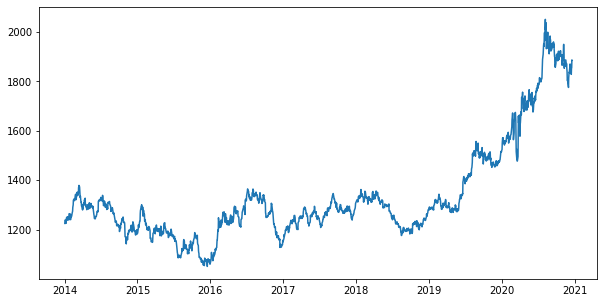

In [57]:
df_stock.index = df_stock['Date']
plt.figure(figsize=(10,5))
plt.plot(df_stock['Close'], label='Close Price history')

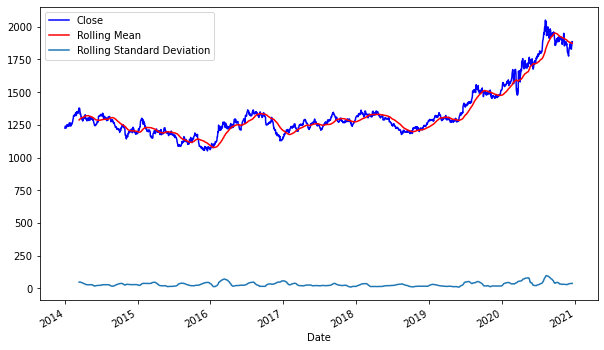

In [8]:
close = df_stock['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10, 6))
df_stock['Close'].plot(color = 'b', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()

In [9]:
train = df_stock[:1500]
test = df_stock[1500:]

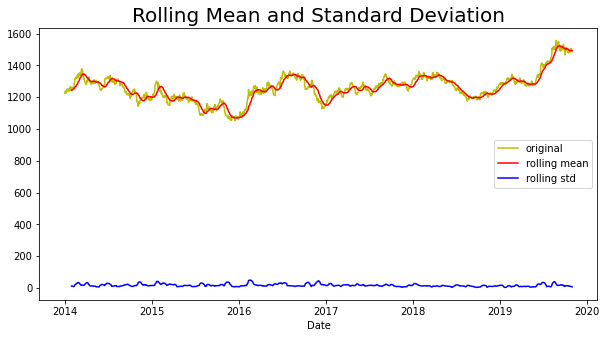

Results of dickey fuller test
ADF Test Statistic : -1.324550551628027
p-value : 0.6178669134549046
#Lags Used : 10
Number of Observations Used : 1489
Data is non-stationary 


In [12]:
# Checking the stationarity of data
def test_stationarity(timeseries):
  rolmean = timeseries.rolling(20).mean()
  rolstd = timeseries.rolling(20).std()
  plt.figure(figsize = (10,5))
  plt.plot(timeseries, color = 'y', label = 'original')
  plt.plot(rolmean, color = 'r', label = 'rolling mean')
  plt.plot(rolstd, color = 'b', label = 'rolling std')
  plt.xlabel('Date')
  plt.legend()
  plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
  plt.show(block = False)
  print('Results of dickey fuller test')
  result = adfuller(timeseries, autolag = 'AIC')
  labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
  for value,label in zip(result, labels):
    print(label+' : '+str(value))
  if result[1] <= 0.05:
    print("Data is stationary")
  else:
    print("Data is non-stationary ")
test_stationarity(train['Close'])

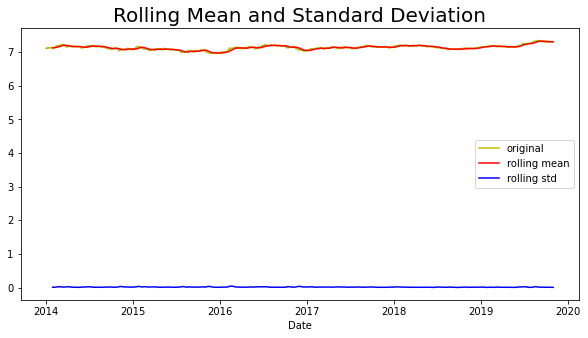

Results of dickey fuller test
ADF Test Statistic : -1.5123236597897536
p-value : 0.5274064309628217
#Lags Used : 10
Number of Observations Used : 1489
Data is non-stationary 


In [13]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

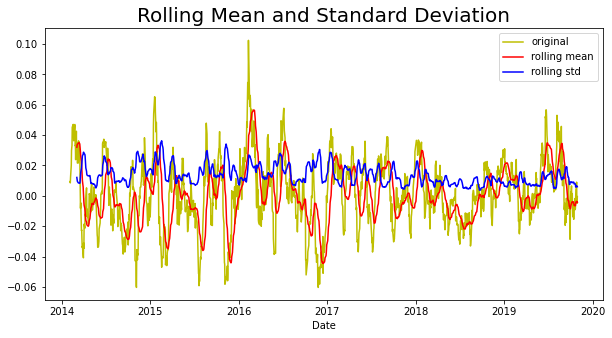

Results of dickey fuller test
ADF Test Statistic : -7.990499745014186
p-value : 2.481933437256026e-12
#Lags Used : 12
Number of Observations Used : 1464
Data is stationary


In [14]:
train_roll_mean = train_log.rolling(24).mean() 
train_log_diff = train_log - train_roll_mean
train_log_diff.dropna(inplace = True)
test_stationarity(train_log_diff)

In [15]:
from pmdarima import auto_arima
model=auto_arima(train_log)
model

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [16]:
model = auto_arima(train_log, information_criterion='bic', trace = True)
model.fit(train_log)

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=-10114.959, Time=1.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=-10137.356, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=-10133.248, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=-10133.285, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=-10144.278, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=-10125.876, Time=0.43 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.853 seconds


ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [46]:
predictions = model.predict(n_periods=len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])
predictions.head()

,Prediction
Date,
2019-10-31 00:00:00+00:00,7.308677
2019-11-01 00:00:00+00:00,7.308677
2019-11-03 00:00:00+00:00,7.308677
2019-11-04 00:00:00+00:00,7.308677
2019-11-05 00:00:00+00:00,7.308677


In [18]:
arima_model= ARIMA(train_log, order=(0, 1, 0)) 
results_arima=arima_model.fit()
results_arima.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 1499
Model:                 ARIMA(0, 1, 0)   Log Likelihood                5075.991
Method:                           css   S.D. of innovations              0.008
Date:                Sun, 20 Dec 2020   AIC                         -10147.981
Time:                        14:49:51   BIC                         -10137.356
Sample:                             1   HQIC                        -10144.023
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.625      0.532      -0.000       0.001
==============================================================================
"""

In [19]:
results_arima.forecast()

(array([7.30880879]), array([0.00818715]), array([[7.29276228, 7.3248553 ]]))

In [20]:
len(train_log)

1500

In [21]:
results_arima.predict(1000,1500).head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


999     0.000132
1000    0.000132
1001    0.000132
1002    0.000132
1003    0.000132
dtype: float64

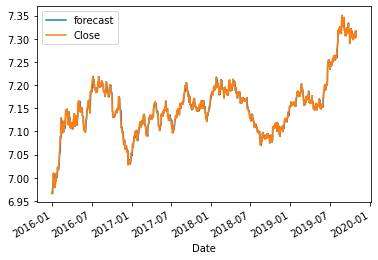

In [22]:
results_arima.plot_predict(start=500)
plt.show()

Text(0, 0.5, 'Actual Stock Price')

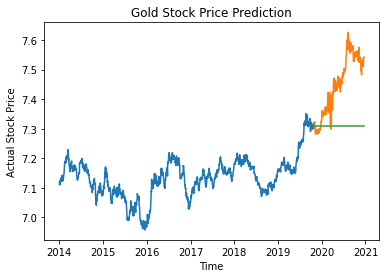

In [23]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('Gold Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

In [24]:
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

RMSE :  0.16896973821087338


In [27]:
#TEXT ANALYSIS(SENTIMENT_ANALYSIS)
df_news = pd.read_csv('india-news-headlines (1).csv')
df_news=df_news.rename(columns={"publish_date": "Date",'headline_text':"News"})
df_news

,Date,headline_category,News
0,20010101,sports.wwe,win over cena satisfying but defeating underta...
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa
...,...,...,...
3297167,20200630,gadgets-news,why tiktok removed 1 65 crore videos in india
3297168,20200630,entertainment.hindi.bollywood,apurva asrani calls alia bhatts mother soni ra...
3297169,20200630,entertainment.hindi.bollywood,kangana ranaut gets a doll version of herself ...
3297170,20200630,entertainment.hindi.bollywood,meezaan jaffrey reminisces his childhood days ...


In [28]:
df_news.drop('headline_category', axis = 1, inplace=True)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3297172 entries, 0 to 3297171
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Date    int64 
 1   News    object
dtypes: int64(1), object(1)
memory usage: 50.3+ MB


In [29]:
df_news['Date'] = pd.to_datetime(df_news['Date'],format= '%Y%m%d',utc=True)
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news

,Date,News
0,2001-01-01 00:00:00+00:00,win over cena satisfying but defeating underta...
1,2001-01-02 00:00:00+00:00,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-03 00:00:00+00:00,Powerless north India gropes in the dark Think...
3,2001-01-04 00:00:00+00:00,The string that pulled Stephen Hawking to Indi...
4,2001-01-05 00:00:00+00:00,Light combat craft takes India into club class...
...,...,...
7075,2020-06-26 00:00:00+00:00,Containment zone residents slam high prices ch...
7076,2020-06-27 00:00:00+00:00,like me i wont let you have a toxic relationsh...
7077,2020-06-28 00:00:00+00:00,Atanu Ghosh plans to rewrite old scripts to ma...
7078,2020-06-29 00:00:00+00:00,6 hot and stylish bikini looks of Katrina Kaif...


In [30]:
from nltk.tokenize import word_tokenize
def clean_text(df_news):
    df_news = word_tokenize(df_news) # Create tokens
    df_news= " ".join(df_news) # Join tokens
    df_news = [char for char in df_news if char not in string.punctuation] # Remove punctuations
    df_news = ''.join(df_news) # Join the letters
    df_news = [word for word in df_news.split() if word.lower() not in stopwords.words('english')] # Remove common english words (I, you, we,...)
    return " ".join(df_news)

In [31]:
df_news['cleaned_text'] = df_news['News'].apply(clean_text)
df_news

,Date,News,cleaned_text
0,2001-01-01 00:00:00+00:00,win over cena satisfying but defeating underta...,win cena satisfying defeating undertaker bigge...
1,2001-01-02 00:00:00+00:00,Status quo will not be disturbed at Ayodhya; s...,Status quo disturbed Ayodhya says Vajpayee Fis...
2,2001-01-03 00:00:00+00:00,Powerless north India gropes in the dark Think...,Powerless north India gropes dark Think Laxman...
3,2001-01-04 00:00:00+00:00,The string that pulled Stephen Hawking to Indi...,string pulled Stephen Hawking India Vajpayee g...
4,2001-01-05 00:00:00+00:00,Light combat craft takes India into club class...,Light combat craft takes India club class Hawk...
...,...,...,...
7075,2020-06-26 00:00:00+00:00,Containment zone residents slam high prices ch...,Containment zone residents slam high prices ch...
7076,2020-06-27 00:00:00+00:00,like me i wont let you have a toxic relationsh...,like wont let toxic relationship food Major Ra...
7077,2020-06-28 00:00:00+00:00,Atanu Ghosh plans to rewrite old scripts to ma...,Atanu Ghosh plans rewrite old scripts make rel...
7078,2020-06-29 00:00:00+00:00,6 hot and stylish bikini looks of Katrina Kaif...,6 hot stylish bikini looks Katrina Kaif Anna E...


In [32]:
!pip install textblob

In [34]:
from textblob import TextBlob
def generate_polarity(text):
    sentiment = TextBlob(text).sentiment.polarity
    return sentiment

In [35]:
sentiment = df_news['cleaned_text'].apply(generate_polarity)
sentiment_polarity = sentiment.to_frame()
#sentiment_polarity.head()

In [36]:
def generate_subjectivity(text):
    sentiment = TextBlob(text).sentiment.subjectivity
    return sentiment
sentiment = df_news['cleaned_text'].apply(generate_subjectivity)
sentiment_subjectivity = sentiment.to_frame()
#sentiment_subjectivity.head()

In [38]:
df_news['polarity'] = sentiment_polarity
df_news['subjectivity'] = sentiment_subjectivity
df_news

,Date,News,cleaned_text,polarity,subjectivity
0,2001-01-01 00:00:00+00:00,win over cena satisfying but defeating underta...,win cena satisfying defeating undertaker bigge...,0.433333,0.633333
1,2001-01-02 00:00:00+00:00,Status quo will not be disturbed at Ayodhya; s...,Status quo disturbed Ayodhya says Vajpayee Fis...,0.121014,0.263406
2,2001-01-03 00:00:00+00:00,Powerless north India gropes in the dark Think...,Powerless north India gropes dark Think Laxman...,0.112500,0.433333
3,2001-01-04 00:00:00+00:00,The string that pulled Stephen Hawking to Indi...,string pulled Stephen Hawking India Vajpayee g...,0.054074,0.442101
4,2001-01-05 00:00:00+00:00,Light combat craft takes India into club class...,Light combat craft takes India club class Hawk...,0.266578,0.477807
...,...,...,...,...,...
7075,2020-06-26 00:00:00+00:00,Containment zone residents slam high prices ch...,Containment zone residents slam high prices ch...,0.043772,0.360802
7076,2020-06-27 00:00:00+00:00,like me i wont let you have a toxic relationsh...,like wont let toxic relationship food Major Ra...,0.068910,0.381466
7077,2020-06-28 00:00:00+00:00,Atanu Ghosh plans to rewrite old scripts to ma...,Atanu Ghosh plans rewrite old scripts make rel...,0.039826,0.400228
7078,2020-06-29 00:00:00+00:00,6 hot and stylish bikini looks of Katrina Kaif...,6 hot stylish bikini looks Katrina Kaif Anna E...,0.045736,0.378385


In [39]:
df_news['polarity_encoded'] = ['positive' if x > 0 else 'negative' if x < 0 else 'neutral' for x in df_news['polarity']]
df_news['polarity_encoded'].value_counts()

positive    6707
negative     363
neutral       10
Name: polarity_encoded, dtype: int64

In [40]:
sia = SentimentIntensityAnalyzer()

df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['cleaned_text']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['cleaned_text']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['cleaned_text']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['cleaned_text']]
df_news

,Date,News,cleaned_text,polarity,subjectivity,polarity_encoded,Compound,Negative,Neutral,Positive
0,2001-01-01 00:00:00+00:00,win over cena satisfying but defeating underta...,win cena satisfying defeating undertaker bigge...,0.433333,0.633333,positive,0.6369,0.181,0.347,0.472
1,2001-01-02 00:00:00+00:00,Status quo will not be disturbed at Ayodhya; s...,Status quo disturbed Ayodhya says Vajpayee Fis...,0.121014,0.263406,positive,-0.9662,0.164,0.735,0.101
2,2001-01-03 00:00:00+00:00,Powerless north India gropes in the dark Think...,Powerless north India gropes dark Think Laxman...,0.112500,0.433333,positive,0.4019,0.137,0.719,0.145
3,2001-01-04 00:00:00+00:00,The string that pulled Stephen Hawking to Indi...,string pulled Stephen Hawking India Vajpayee g...,0.054074,0.442101,positive,0.5423,0.123,0.754,0.123
4,2001-01-05 00:00:00+00:00,Light combat craft takes India into club class...,Light combat craft takes India club class Hawk...,0.266578,0.477807,positive,0.9854,0.144,0.665,0.190
...,...,...,...,...,...,...,...,...,...,...
7075,2020-06-26 00:00:00+00:00,Containment zone residents slam high prices ch...,Containment zone residents slam high prices ch...,0.043772,0.360802,positive,-0.9998,0.156,0.750,0.094
7076,2020-06-27 00:00:00+00:00,like me i wont let you have a toxic relationsh...,like wont let toxic relationship food Major Ra...,0.068910,0.381466,positive,-0.9998,0.151,0.756,0.093
7077,2020-06-28 00:00:00+00:00,Atanu Ghosh plans to rewrite old scripts to ma...,Atanu Ghosh plans rewrite old scripts make rel...,0.039826,0.400228,positive,-0.9999,0.160,0.756,0.085
7078,2020-06-29 00:00:00+00:00,6 hot and stylish bikini looks of Katrina Kaif...,6 hot stylish bikini looks Katrina Kaif Anna E...,0.045736,0.378385,positive,-0.9998,0.154,0.755,0.092


In [41]:
print("The most positive news:",df_news.iloc[df_news['polarity'].idxmax()]['News'])
print("The most negative news:",df_news.iloc[df_news['polarity'].idxmin()]['News']) 
print("The most subjective news:",df_news.iloc[df_news['subjectivity'].idxmax()]['News'])
print("The most objective news:",df_news.iloc[df_news['subjectivity'].idxmin()]['News']) 

The most positive news: Of power and potatoes A Happy Surprise Looking for Digs Is the home of the brave still the land of the free?
The most negative news: Antony elected Kerala chief minister Pak not yet in rogues gallery; says US India goes on MoU signing spree with Malaysia Advani blames Rao govt for Ayodhya crisis BJP turns to RSS in search for lost ideology Law and Disorder Has hoity-toity Jaya changed at all? Sonia holds olive branch to Jaya If Jaya can; why can't Lalooji; ask loyalists Four Congmen race for Chief Ministership Jaya was here; there and everywhere Former SC Judge endorses Jaya's chief ministership Chidambaram threatens to take CM issue to court Antony made CM; after a few hiccups Leader extracts his pound of flesh Antony to UDF: don't get drunk on power
The most subjective news: Nepal's gripping tale of sorrow Mujhe Kucch Kehna Hai
The most objective news: Fend for yourselves; Pande tells doctors Bureaucracy undermining legislature's 'existence' State police colla

In [65]:
df_merge = pd.merge(df_stock,df_news,how='inner', on="Date")
df_merge

,Date,Open,High,Low,Close,Adj Close,Volume,News,cleaned_text,polarity,subjectivity,polarity_encoded,Compound,Negative,Neutral,Positive
0,2014-01-02 00:00:00+00:00,1204.300049,1227.300049,1204.300049,1225.000000,1225.000000,209.0,10 best movie catch phrases of all times Ranbi...,10 best movie catch phrases times Ranbir Kapoo...,0.081661,0.460266,positive,-0.9996,0.156,0.728,0.116
1,2014-01-03 00:00:00+00:00,1221.699951,1239.000000,1221.699951,1238.400024,1238.400024,142.0,I find comedy tough: Abhishek Bachchan Virat K...,find comedy tough Abhishek Bachchan Virat Kohl...,0.028246,0.371817,positive,-0.9998,0.168,0.717,0.116
2,2014-01-06 00:00:00+00:00,1232.800049,1247.000000,1221.900024,1237.800049,1237.800049,127.0,Srinagara Kitty sports stylish look in new fil...,Srinagara Kitty sports stylish look new film A...,0.048331,0.387522,positive,-0.9997,0.160,0.723,0.118
3,2014-01-07 00:00:00+00:00,1239.300049,1242.400024,1226.300049,1229.400024,1229.400024,73.0,Koffee With Karan Sonam Kapoor and Anil Kapoor...,Koffee Karan Sonam Kapoor Anil Kapoor Koffee K...,-0.003358,0.399507,negative,-0.9999,0.178,0.736,0.086
4,2014-01-08 00:00:00+00:00,1227.500000,1227.500000,1218.599976,1225.300049,1225.300049,189.0,Celebrity couples we would like to see as pare...,Celebrity couples would like see parents five ...,0.061007,0.376576,positive,-0.9998,0.169,0.724,0.107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1691,2020-06-25 00:00:00+00:00,1761.699951,1764.800049,1759.800049,1762.099976,1762.099976,207.0,Truck firms look for new export markets to sel...,Truck firms look new export markets sell BS6 r...,0.002395,0.388167,positive,-0.9999,0.169,0.760,0.071
1692,2020-06-26 00:00:00+00:00,1766.000000,1772.500000,1764.699951,1772.500000,1772.500000,640.0,Containment zone residents slam high prices ch...,Containment zone residents slam high prices ch...,0.043772,0.360802,positive,-0.9998,0.156,0.750,0.094
1693,2020-06-28 00:00:00+00:00,1789.199951,1790.400024,1785.000000,1785.300049,1785.300049,500645.0,Atanu Ghosh plans to rewrite old scripts to ma...,Atanu Ghosh plans rewrite old scripts make rel...,0.039826,0.400228,positive,-0.9999,0.160,0.756,0.085
1694,2020-06-29 00:00:00+00:00,1779.800049,1780.199951,1774.300049,1774.800049,1774.800049,584.0,6 hot and stylish bikini looks of Katrina Kaif...,6 hot stylish bikini looks Katrina Kaif Anna E...,0.045736,0.378385,positive,-0.9998,0.154,0.755,0.092


In [66]:
df = df_merge[['Close','subjectivity', 'polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
df

,Close,subjectivity,polarity,Compound,Negative,Neutral,Positive
0,1225.000000,0.460266,0.081661,-0.9996,0.156,0.728,0.116
1,1238.400024,0.371817,0.028246,-0.9998,0.168,0.717,0.116
2,1237.800049,0.387522,0.048331,-0.9997,0.160,0.723,0.118
3,1229.400024,0.399507,-0.003358,-0.9999,0.178,0.736,0.086
4,1225.300049,0.376576,0.061007,-0.9998,0.169,0.724,0.107
...,...,...,...,...,...,...,...
1691,1762.099976,0.388167,0.002395,-0.9999,0.169,0.760,0.071
1692,1772.500000,0.360802,0.043772,-0.9998,0.156,0.750,0.094
1693,1785.300049,0.400228,0.039826,-0.9999,0.160,0.756,0.085
1694,1774.800049,0.378385,0.045736,-0.9998,0.154,0.755,0.092


In [67]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_df = pd.DataFrame(sc.fit_transform(df))
new_df.columns = df.columns
new_df.index = df.index
new_df.head()

,Close,subjectivity,polarity,Compound,Negative,Neutral,Positive
0,0.234708,0.956647,0.629912,0.00020,0.495146,0.386792,0.468468
1,0.252762,0.346929,0.356654,0.00010,0.611650,0.283019,0.468468
2,0.251954,0.455192,0.459405,0.00015,0.533981,0.339623,0.486486
3,0.240636,0.537808,0.194970,0.00005,0.708738,0.462264,0.198198
4,0.235112,0.379733,0.524250,0.00010,0.621359,0.349057,0.387387


In [68]:
X = new_df.drop('Close', axis=1)
y =new_df['Close']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [69]:
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor()
dec_tree.fit(x_train, y_train)
predictions = dec_tree.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.045067886011537626


In [70]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)
print(mean_squared_error(prediction,y_test))

0.021332802016011624


In [71]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)
predictions = adb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.025459082974434215


# OTHER MODELS THAT CAN BE USED: SVM; LDA; XGBoost etc..